# Creation of baseline model for GRI

This notebook loads data and formats it for injestion by several initial models. Baseline performance is established for a prediction of future Glycemic Risk Index (GRI). Specifically, users are classified based on whether they have a GRI above 40 in a future 2 week period based on the previous 2 weeks of daily-aggregated CGM data. Note that GRI has been correlated to clinicians' ratings of glycemia in [this paper](https://journals.sagepub.com/doi/full/10.1177/19322968221085273).

## Import statements

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'axes.labelsize':16, 'axes.titlesize':20})
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import OneHotEncoder

## Data loading

In [85]:
users_info_df = pd.read_csv('../../data/users_info.csv')
users_ds_df = pd.read_csv('../../data/users_daily_stats.csv')

## Quick look at variables we have in user info file

In [86]:
users_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4130 entries, 0 to 4129
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           4130 non-null   int64  
 1   ID                   4130 non-null   int64  
 2   DIABETES_TYPE        4130 non-null   object 
 3   GENDER               4130 non-null   object 
 4   DATE_OF_BIRTH        4130 non-null   object 
 5   CURRENT_AGE          4130 non-null   int64  
 6   AGE_WHEN_REGISTERED  4130 non-null   int64  
 7   APPLICATION_NAME     4128 non-null   object 
 8   OS                   4128 non-null   object 
 9   HAS_CGM              4130 non-null   bool   
 10  HAS_PUMP             4130 non-null   bool   
 11  HAS_METER            4130 non-null   bool   
 12  SYNC_COUNT           4130 non-null   int64  
 13  EVENT_COUNT          879 non-null    float64
 14  FOOD_COUNT           879 non-null    float64
 15  EXERCISE_COUNT       879 non-null    f

## Generate additional variables from user info
Create variable for length of glooko app use, has_other_count (boolean), and use one-hot encoder on APPLICATION_NAME and OS (to separate those categorical variables out into individual booleans). Note that APPLICATION_NAME is the application used to upload glucose data, while OS is the system operating system used for the upload.

In [87]:
users_info_df['APP_LENGTH'] = users_info_df['CURRENT_AGE'] - \
                                users_info_df['AGE_WHEN_REGISTERED']

In [88]:
users_info_df['HAS_OTHER_COUNT'] = users_info_df['EVENT_COUNT'].notnull()

In [89]:
# One hot encode the APPLICATION_NAME variable
users_info_df = pd.concat(
    [users_info_df, 
     users_info_df['APPLICATION_NAME'].str.get_dummies(sep=",")
    ], axis=1)

In [90]:
# One hot encode the OS variable
users_info_df = pd.concat(
    [users_info_df, 
     users_info_df['OS'].str.get_dummies(sep=",")
    ], axis=1)

In [91]:
users_info_df.columns

Index(['Unnamed: 0', 'ID', 'DIABETES_TYPE', 'GENDER', 'DATE_OF_BIRTH',
       'CURRENT_AGE', 'AGE_WHEN_REGISTERED', 'APPLICATION_NAME', 'OS',
       'HAS_CGM', 'HAS_PUMP', 'HAS_METER', 'SYNC_COUNT', 'EVENT_COUNT',
       'FOOD_COUNT', 'EXERCISE_COUNT', 'MEDICATION_COUNT', 'APP_LENGTH',
       'HAS_OTHER_COUNT', 'c4c', 'kiosk', 'logbook', 'patient_uploader',
       'server', 'android', 'browser', 'ios'],
      dtype='object')

In [92]:
users_info_var_select = ['GENDER','CURRENT_AGE','HAS_PUMP','HAS_METER',
                        'SYNC_COUNT','APP_LENGTH','HAS_OTHER_COUNT',
                        'c4c','kiosk','logbook','patient_uploader',
                        'server','android','browser','ios']

## Quick look at variables we have in daily stats file

In [93]:
users_ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375830 entries, 0 to 375829
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               375830 non-null  int64  
 1   USER_ID                  375830 non-null  int64  
 2   TIME_CGM_ACTIVE          375830 non-null  float64
 3   AVERAGE_VALUE            375830 non-null  float64
 4   READING_COUNT            375830 non-null  int64  
 5   ABOVE_180                375830 non-null  int64  
 6   ABOVE_250                375830 non-null  int64  
 7   ABOVE_400                375830 non-null  int64  
 8   BELOW_50                 375830 non-null  int64  
 9   BELOW_54                 375830 non-null  int64  
 10  BELOW_60                 375830 non-null  int64  
 11  BELOW_70                 375830 non-null  int64  
 12  LOWEST_VALUE             375830 non-null  float64
 13  HIGHEST_VALUE            375830 non-null  float64
 14  DATE

## Generate additional (time series) variables from daily stats

Note that some users don't have 100% active time. (And some users have over 100% active time.) For this analysis we will assume the data we do have is representative of the entire day. Under this assumption, if there are 5 readings below 70 out of 100 readings for the day, then this indicates the user had 5% of time below range and we will assume the user had 5% of time below range for the entire day. In this section we will change the units of the ABOVE_* and BELOW_* variables from 'counts' to '% of time'. Note that a typical glucose monitor records readings every five minutes. Therefore, an active time of 1.0 (100%) is equal to 288 readings (24 hours * 60 min / hr * 1 reading / 5 min = 288 readings).

In [94]:
users_ds_df['TIME_CGM_ACTIVE'].describe()

count    375830.000000
mean          0.999197
std           0.161408
min           0.003472
25%           1.000000
50%           1.000000
75%           1.000000
max           3.274306
Name: TIME_CGM_ACTIVE, dtype: float64

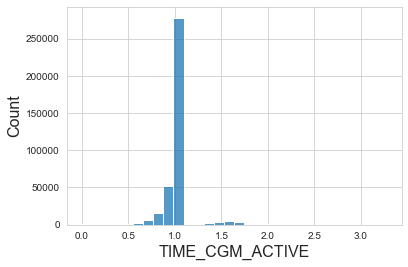

In [95]:
sns.histplot(users_ds_df['TIME_CGM_ACTIVE'], bins=30);

This is what the above/below count variables look like.

In [96]:
temp_vars = ['TIME_CGM_ACTIVE','ABOVE_180','ABOVE_250','ABOVE_400',
                 'BELOW_50','BELOW_54','BELOW_60','BELOW_70']
temp_vars.append('READING_COUNT')
users_ds_df[temp_vars].head(12)

,TIME_CGM_ACTIVE,ABOVE_180,ABOVE_250,ABOVE_400,BELOW_50,BELOW_54,BELOW_60,BELOW_70,READING_COUNT
0,1.000000,87,22,0,0,0,2,5,288
1,1.000000,137,39,0,0,0,0,3,288
2,1.000000,13,0,0,0,0,0,6,288
3,0.986111,17,0,0,0,0,0,10,284
4,1.000000,27,0,0,0,4,12,27,288
5,1.003472,175,102,0,0,0,0,0,289
6,1.000000,0,0,0,0,0,8,27,288
7,1.000000,222,93,0,0,0,0,0,288
8,1.000000,52,0,0,0,0,0,3,288
9,1.000000,36,16,0,0,0,0,1,288


In [97]:
# Change the units of these reading counts variable from counts to % of time
read_cnt_vars = ['ABOVE_180','ABOVE_250','ABOVE_400',
                 'BELOW_50','BELOW_54','BELOW_60','BELOW_70']
for i,var in enumerate(read_cnt_vars):
    #users_ds_df[var] = users_ds_df[var] / users_ds_df['TIME_CGM_ACTIVE']
    users_ds_df[var] = round(100 * users_ds_df[var] / 
                             users_ds_df['READING_COUNT'],2)
users_ds_df[temp_vars].head(12)

,TIME_CGM_ACTIVE,ABOVE_180,ABOVE_250,ABOVE_400,BELOW_50,BELOW_54,BELOW_60,BELOW_70,READING_COUNT
0,1.000000,30.21,7.64,0.0,0.0,0.00,0.69,1.74,288
1,1.000000,47.57,13.54,0.0,0.0,0.00,0.00,1.04,288
2,1.000000,4.51,0.00,0.0,0.0,0.00,0.00,2.08,288
3,0.986111,5.99,0.00,0.0,0.0,0.00,0.00,3.52,284
4,1.000000,9.38,0.00,0.0,0.0,1.39,4.17,9.38,288
5,1.003472,60.55,35.29,0.0,0.0,0.00,0.00,0.00,289
6,1.000000,0.00,0.00,0.0,0.0,0.00,2.78,9.38,288
7,1.000000,77.08,32.29,0.0,0.0,0.00,0.00,0.00,288
8,1.000000,18.06,0.00,0.0,0.0,0.00,0.00,1.04,288
9,1.000000,12.50,5.56,0.0,0.0,0.00,0.00,0.35,288


In [98]:
users_ds_df["ABOVE_180"].describe()

count    375830.000000
mean         30.836868
std          24.832058
min           0.000000
25%          10.270000
50%          26.040000
75%          46.880000
max         100.000000
Name: ABOVE_180, dtype: float64

In [99]:
users_ds_df["BELOW_70"].describe()

count    375830.000000
mean          2.824835
std           5.234385
min           0.000000
25%           0.000000
50%           0.350000
75%           3.470000
max         100.000000
Name: BELOW_70, dtype: float64

The output above shows the variables after the units have been changed. The variables ABOVE_* and BELOW_* are affected.

Now we will create the Glycemic Risk Index (GRI) variable. The GRI is defined by the formula below. Note that a large value indicates a higher glycemic risk, which is associated with negative health outcomes

In [100]:
# Create variable for Glycemic Risk Index (GRI)
# GRI = (3.0 × VLow) + (2.4 × Low) + (1.6 × VHigh) + (0.8 × High)
# or alternatively: GRI = (3.0 × HypoComp) + (1.6 × HyperComp)
# where Hypoglycemia Component = VLow + (0.8 × Low)
#   and Hyperglycemia Component = VHigh + (0.5 × High)
# and where VLow = # time < 54, Low = # time from 54 to < 70
#          VHigh = # time > 250, High = # time from 250 to > 180
GRI_temp = pd.DataFrame()
GRI_temp['VLow'] = users_ds_df['BELOW_54']
GRI_temp['Low'] = users_ds_df['BELOW_70'] - users_ds_df['BELOW_54']
GRI_temp['VHigh'] = users_ds_df['ABOVE_250']
GRI_temp['High'] = users_ds_df['ABOVE_180'] - users_ds_df['ABOVE_250']

In [101]:
# Create HypoComp, HyperComp, and GRI for each user and day in the daily stats dataframe
users_ds_df['GRI_HYPO'] = GRI_temp['VLow'] + 0.8 * GRI_temp['Low']
users_ds_df['GRI_HYPER'] = GRI_temp['VHigh'] + 0.5 * GRI_temp['High']
users_ds_df['GRI'] = 3 * users_ds_df['GRI_HYPO'] \
                     + 1.6 * users_ds_df['GRI_HYPER']

In [102]:
# sort values by USER_ID and DATE
users_ds_df.sort_values(by=['USER_ID','DATE'], inplace=True)
users_ds_df.head(10).T

,3828,4419,11018,15663,18285,20938,27770,31927,35205,39760
Unnamed: 0,3828,4419,11018,15663,18285,20938,27770,31927,35205,39760
USER_ID,0,0,0,0,0,0,0,0,0,0
TIME_CGM_ACTIVE,1.0,1.0,1.0,1.0,1.0,1.0,0.899306,0.996528,1.0,1.0
AVERAGE_VALUE,218.4375,241.354167,257.315972,199.736111,192.989583,242.006944,304.602317,231.735192,238.920139,211.03125
READING_COUNT,288,288,288,288,288,288,259,287,288,288
ABOVE_180,82.99,88.54,83.68,55.56,59.38,70.83,100.0,74.22,87.5,67.36
ABOVE_250,23.96,37.5,64.58,24.65,0.0,55.56,78.76,56.79,48.61,25.69
ABOVE_400,0.0,0.0,0.0,0.0,0.0,0.0,0.39,0.0,0.0,0.0
BELOW_50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BELOW_54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
users_ds_df[["LOWEST_VALUE","HIGHEST_VALUE"]].describe()

,LOWEST_VALUE,HIGHEST_VALUE
count,375830.000000,375830.00000
mean,74.545346,266.64763
std,27.175515,66.25717
min,39.000000,39.00000
25%,57.000000,217.00000
50%,69.000000,260.00000
75%,86.000000,311.00000
max,401.000000,401.00000


We also need to create the test (prediction) variables. We will use the average GRI for last 14 days and the average GRI for the next (future) 14 days. Note that the GRI has a notable amount of variation day-to-day, which is why we will be using average values to get a sense of either 'improvement' or 'worsening' of glycemic risk on a longer time scale. 

In [104]:
users_ds_df[['DATE','GRI']].head(20)

,DATE,GRI
3828,2021-04-01,85.560
4419,2021-04-02,100.832
11018,2021-04-03,118.608
15663,2021-04-04,64.168
18285,2021-04-05,47.504
20938,2021-04-06,101.112
27770,2021-04-07,143.008
31927,2021-04-08,106.488
35205,2021-04-09,108.888
39760,2021-04-10,74.440


In [105]:
users_ds_df['GRI_PAST_2WK'] = users_ds_df['GRI'].rolling(
                                14).mean()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=7)
users_ds_df['GRI_FUTURE_1WK'] = users_ds_df['GRI'].rolling(
                    window=indexer, min_periods=1).mean()
indexer2 = pd.api.indexers.FixedForwardWindowIndexer(window_size=14)
users_ds_df['GRI_FUTURE_2WK'] = users_ds_df['GRI'].rolling(
                    window=indexer2, min_periods=1).mean()

In [106]:
users_ds_df[['DATE','GRI','GRI_PAST_2WK','GRI_FUTURE_1WK','GRI_FUTURE_2WK']].head(20)

,DATE,GRI,GRI_PAST_2WK,GRI_FUTURE_1WK,GRI_FUTURE_2WK
3828,2021-04-01,85.560,NaN,94.398857,98.278286
4419,2021-04-02,100.832,NaN,97.388571,99.508000
11018,2021-04-03,118.608,NaN,98.539429,97.702857
15663,2021-04-04,64.168,NaN,92.229714,90.708571
18285,2021-04-05,47.504,NaN,99.452571,88.961714
20938,2021-04-06,101.112,NaN,106.277714,87.949143
27770,2021-04-07,143.008,NaN,107.468571,83.326286
31927,2021-04-08,106.488,NaN,102.157714,74.301714
35205,2021-04-09,108.888,NaN,101.627429,67.211429
39760,2021-04-10,74.440,NaN,96.866286,62.509143


In [107]:
users_ds_df[['TIME_CGM_ACTIVE','AVERAGE_VALUE','DATE',
             'GRI_HYPO','GRI_HYPER','GRI']
           ][users_ds_df['USER_ID'] == 4036
            ].head(10)

,TIME_CGM_ACTIVE,AVERAGE_VALUE,DATE,GRI_HYPO,GRI_HYPER,GRI
7,1.000000,226.468750,2021-04-01,0.000,54.685,87.496
8185,0.906250,205.015326,2021-04-02,0.000,38.890,62.224
10716,1.000000,217.815972,2021-04-03,0.000,48.785,78.056
12841,1.000000,216.138889,2021-04-04,0.000,52.255,83.608
20569,1.000000,254.333333,2021-04-05,0.000,68.055,108.888
24205,0.972222,269.664286,2021-04-06,0.000,83.035,132.856
25602,0.993056,181.356643,2021-04-07,0.280,34.265,55.664
30774,1.000000,173.694444,2021-04-08,1.112,28.125,48.336
37067,0.972222,184.275000,2021-04-09,0.000,35.535,56.856
39937,0.972222,179.328571,2021-04-10,0.000,31.425,50.280


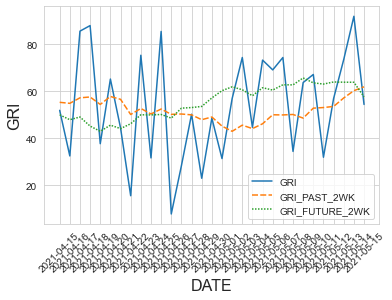

In [108]:
user_num = 900
single_user = users_ds_df[users_ds_df['USER_ID'] == user_num].sort_values(by="DATE")
single_user = single_user.set_index(single_user["DATE"])
sns.lineplot(data=single_user[[
    "GRI","GRI_PAST_2WK","GRI_FUTURE_2WK"]].iloc[14:45]);
plt.xticks(rotation=45);
plt.ylabel("GRI");

The figure above shows how the GRI variables (daily, and 2-week past and future averages) change over a month-long period.

The figure below shows that for each of the days listed, every user in the dataset (a total of 4130 users) have data.

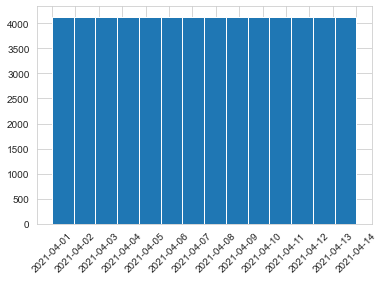

In [109]:
plt.hist(users_ds_df['DATE'][users_ds_df['DATE'] <= '2021-04-14'], bins=14)
plt.xticks(rotation=45);

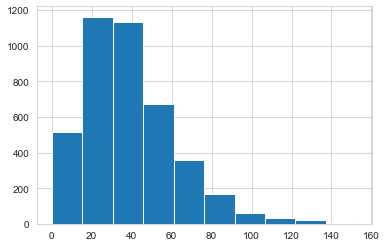

In [110]:
plt.hist(users_ds_df['GRI_FUTURE_2WK'][users_ds_df['DATE'] == '2021-04-14']);

The figure above shows the distribution of future 2-week average GRI for every user on a specific date. As shown below, the mean GRI is 39 and median is 36.

In [111]:
users_ds_df['GRI_FUTURE_2WK'][users_ds_df['DATE'] == '2021-04-14'].describe()

count    4130.000000
mean       39.118552
std        22.869756
min         0.099429
25%        22.390893
50%        35.553286
75%        51.138250
max       152.405143
Name: GRI_FUTURE_2WK, dtype: float64

In [112]:
(users_ds_df['GRI_FUTURE_2WK'][users_ds_df['DATE'] == '2021-04-14'] > 40).sum()

1726

In [113]:
1726/4130

0.4179176755447942

In [114]:
(users_ds_df['GRI_PAST_2WK'][users_ds_df['DATE'] == '2021-04-14'] > 40).sum()

1707

In [115]:
((users_ds_df['GRI_PAST_2WK'][users_ds_df['DATE'] == '2021-04-14'] > 40)
& (users_ds_df['GRI_FUTURE_2WK'][users_ds_df['DATE'] == '2021-04-14'] > 40)).sum()

1455

In [116]:
((users_ds_df['GRI_PAST_2WK'][users_ds_df['DATE'] == '2021-04-14'] < 40)
& (users_ds_df['GRI_FUTURE_2WK'][users_ds_df['DATE'] == '2021-04-14'] > 40)).sum()

271

In [117]:
users_go_over_thd = ((users_ds_df['GRI_PAST_2WK'][users_ds_df['DATE'] == '2021-04-14'] < 40)
& (users_ds_df['GRI_FUTURE_2WK'][users_ds_df['DATE'] == '2021-04-14'] > 40)).reset_index()

In [118]:
((users_ds_df['GRI_PAST_2WK'][users_ds_df['DATE'] == '2021-04-14'] > 40)
& (users_ds_df['GRI_FUTURE_2WK'][users_ds_df['DATE'] == '2021-04-14'] < 40)).sum()

252

In [119]:
users_go_under_thd = ((users_ds_df['GRI_PAST_2WK'][users_ds_df['DATE'] == '2021-04-14'] > 40)
& (users_ds_df['GRI_FUTURE_2WK'][users_ds_df['DATE'] == '2021-04-14'] < 40)).reset_index()

In [120]:
users_stay_over_thd = ((users_ds_df['GRI_PAST_2WK'][users_ds_df['DATE'] == '2021-04-14'] > 40)
& (users_ds_df['GRI_FUTURE_2WK'][users_ds_df['DATE'] == '2021-04-14'] > 40)).reset_index()

In [121]:
users_stay_under_thd = ((users_ds_df['GRI_PAST_2WK'][users_ds_df['DATE'] == '2021-04-14'] < 40)
& (users_ds_df['GRI_FUTURE_2WK'][users_ds_df['DATE'] == '2021-04-14'] < 40)).reset_index()

In [122]:
users_stay_under_thd[0].head()

0    False
1    False
2    False
3     True
4    False
Name: 0, dtype: bool

In [123]:
((users_ds_df['GRI_PAST_2WK'][users_ds_df['DATE'] == '2021-04-14'] < 40)
& (users_ds_df['GRI_FUTURE_2WK'][users_ds_df['DATE'] == '2021-04-14'] < 40)).sum()

2152

In [124]:
271/4130

0.06561743341404358

In [125]:
users_info_df["CURRENT_AGE"][users_go_over_thd[0]].describe()

count    271.000000
mean      42.579336
std       14.946577
min       18.000000
25%       31.000000
50%       41.000000
75%       54.000000
max       83.000000
Name: CURRENT_AGE, dtype: float64

In [126]:
users_ds_df.columns

Index(['Unnamed: 0', 'USER_ID', 'TIME_CGM_ACTIVE', 'AVERAGE_VALUE',
       'READING_COUNT', 'ABOVE_180', 'ABOVE_250', 'ABOVE_400', 'BELOW_50',
       'BELOW_54', 'BELOW_60', 'BELOW_70', 'LOWEST_VALUE', 'HIGHEST_VALUE',
       'DATE', 'TOTAL_INSULIN', 'TOTAL_BASAL', 'TOTAL_BOLUS',
       'HAS_REMOTE_SMBG_DATA', 'HAS_REMOTE_CGM_DATA',
       'HAS_REMOTE_INSULIN_DATA', 'HAS_IN_CLINIC_SYNC', 'GRI_HYPO',
       'GRI_HYPER', 'GRI', 'GRI_PAST_2WK', 'GRI_FUTURE_1WK', 'GRI_FUTURE_2WK'],
      dtype='object')

In [127]:
dateChoice = '2021-04-14'
# We select variables for a certain day, and then reset the index to the user_id
# Note: the index is the user_id because the data was ordered by user_id (so we don't need to set it explicitly)
X = users_ds_df[['TOTAL_INSULIN', 'TOTAL_BASAL', 'TOTAL_BOLUS',
                'HAS_REMOTE_SMBG_DATA', 'HAS_REMOTE_CGM_DATA',
                'HAS_REMOTE_INSULIN_DATA', 'HAS_IN_CLINIC_SYNC',
                'GRI_FUTURE_2WK'
                ]][users_ds_df['DATE'] == dateChoice] \
                .reset_index().drop(columns='index')

In [128]:
X.head()

,TOTAL_INSULIN,TOTAL_BASAL,TOTAL_BOLUS,HAS_REMOTE_SMBG_DATA,HAS_REMOTE_CGM_DATA,HAS_REMOTE_INSULIN_DATA,HAS_IN_CLINIC_SYNC,GRI_FUTURE_2WK
0,49.15,42.00,7.15,False,True,True,False,54.684000
1,16.80,16.80,0.00,False,True,False,False,92.694286
2,51.60,29.30,22.30,False,True,False,False,52.608857
3,NaN,NaN,NaN,False,True,False,False,17.202571
4,58.15,22.05,36.10,False,True,False,False,52.899429


In [129]:
X.shape

(4130, 8)

In [130]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4130 entries, 0 to 4129
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TOTAL_INSULIN            1710 non-null   float64
 1   TOTAL_BASAL              1710 non-null   float64
 2   TOTAL_BOLUS              1710 non-null   float64
 3   HAS_REMOTE_SMBG_DATA     4128 non-null   object 
 4   HAS_REMOTE_CGM_DATA      4128 non-null   object 
 5   HAS_REMOTE_INSULIN_DATA  4128 non-null   object 
 6   HAS_IN_CLINIC_SYNC       4128 non-null   object 
 7   GRI_FUTURE_2WK           4130 non-null   float64
dtypes: float64(4), object(4)
memory usage: 258.2+ KB


### Also include variables from the user info data file
The index of X is the user id. We will join the data together on ID.

In [131]:
# Remind ourselves of the variable names of the user data dataframe
users_info_df.columns

Index(['Unnamed: 0', 'ID', 'DIABETES_TYPE', 'GENDER', 'DATE_OF_BIRTH',
       'CURRENT_AGE', 'AGE_WHEN_REGISTERED', 'APPLICATION_NAME', 'OS',
       'HAS_CGM', 'HAS_PUMP', 'HAS_METER', 'SYNC_COUNT', 'EVENT_COUNT',
       'FOOD_COUNT', 'EXERCISE_COUNT', 'MEDICATION_COUNT', 'APP_LENGTH',
       'HAS_OTHER_COUNT', 'c4c', 'kiosk', 'logbook', 'patient_uploader',
       'server', 'android', 'browser', 'ios'],
      dtype='object')

In [132]:
# First, create a variable of user data with only the columns we want
users_info_temp = users_info_df.drop(columns=[
    "DIABETES_TYPE","DATE_OF_BIRTH","AGE_WHEN_REGISTERED","APPLICATION_NAME","OS",
    "EVENT_COUNT","FOOD_COUNT","EXERCISE_COUNT","MEDICATION_COUNT","Unnamed: 0"
]).set_index("ID")

In [133]:
users_info_temp.head(10)

,GENDER,CURRENT_AGE,HAS_CGM,HAS_PUMP,HAS_METER,SYNC_COUNT,APP_LENGTH,HAS_OTHER_COUNT,c4c,kiosk,logbook,patient_uploader,server,android,browser,ios
ID,,,,,,,,,,,,,,,,
1332,female,19,True,True,False,1244,5,False,0,1,1,0,0,1,0,1
1333,male,54,True,True,False,1739,3,False,0,0,1,1,0,0,1,1
1334,male,48,True,True,False,1296,1,False,0,0,1,0,0,0,1,0
1335,female,49,True,True,True,930,6,False,0,1,1,0,0,1,0,1
1336,male,33,True,True,False,1221,4,False,0,0,1,0,0,0,0,1
1337,female,28,True,True,False,1270,8,False,0,0,1,0,0,0,0,1
1338,female,31,True,True,False,1260,6,False,0,1,1,0,0,1,0,0
1339,male,46,True,True,False,2008,6,False,0,1,1,0,0,1,1,1
1340,male,40,True,True,True,990,4,False,1,0,1,0,0,1,0,1


In [134]:
# Now, join the two dataframes
X = X.join(users_info_temp)

In [135]:
# Quick check to see that the data is the same - it is
X[X.columns[-16:]].iloc[1332:1337]

,GENDER,CURRENT_AGE,HAS_CGM,HAS_PUMP,HAS_METER,SYNC_COUNT,APP_LENGTH,HAS_OTHER_COUNT,c4c,kiosk,logbook,patient_uploader,server,android,browser,ios
1332,female,19,True,True,False,1244,5,False,0,1,1,0,0,1,0,1
1333,male,54,True,True,False,1739,3,False,0,0,1,1,0,0,1,1
1334,male,48,True,True,False,1296,1,False,0,0,1,0,0,0,1,0
1335,female,49,True,True,True,930,6,False,0,1,1,0,0,1,0,1
1336,male,33,True,True,False,1221,4,False,0,0,1,0,0,0,0,1


## Convert daily variables into structured data format
In this section, we take past data from the last 2 weeks and place it into new variables all in the same row.

In [136]:
# These variables we will make into multiple variables for data from the past 2 weeks:
var_proc_2wk = ['TIME_CGM_ACTIVE','AVERAGE_VALUE','ABOVE_250','BELOW_54',
               'LOWEST_VALUE','HIGHEST_VALUE','GRI']

In [137]:
temp = users_ds_df['DATE']
temp.head()

3828     2021-04-01
4419     2021-04-02
11018    2021-04-03
15663    2021-04-04
18285    2021-04-05
Name: DATE, dtype: object

In [139]:
from datetime import datetime


In [62]:
temp2 = datetime.strptime(temp, '%y/%m/%d')

TypeError: strptime() argument 1 must be str, not Series

In [55]:
# We make 14 variables containing all the users, for the last 14 days
dates = ['2021-04-14','2021-04-13','2021-04-12','2021-04-11','2021-04-10',
        '2021-04-09','2021-04-08','2021-04-07','2021-04-06','2021-04-05',
        '2021-04-04','2021-04-03','2021-04-02','2021-04-01']
for j in range(len(dates)):
    globals()[f"data_{j}"] = users_ds_df[var_proc_2wk] \
        [users_ds_df['DATE'] == dates[j]].reset_index()

In [55]:
# We will create 14 values for each variable, one each for each day in the past 2 weeks
for var in var_proc_2wk:
    for j in range(len(dates)):
        X[f"{var}_{j}"] = globals()[f"data_{j}"][var]

/var/folders/jf/8qzdy32d3y9c7v75pkb_34640000gp/T/ipykernel_33447/1243508662.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{var}_{j}"] = globals()[f"data_{j}"][var]
/var/folders/jf/8qzdy32d3y9c7v75pkb_34640000gp/T/ipykernel_33447/1243508662.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{var}_{j}"] = globals()[f"data_{j}"][var]


In [56]:
X.head()

,TOTAL_INSULIN,TOTAL_BASAL,TOTAL_BOLUS,HAS_REMOTE_SMBG_DATA,HAS_REMOTE_CGM_DATA,HAS_REMOTE_INSULIN_DATA,HAS_IN_CLINIC_SYNC,GRI_FUTURE_2WK,GENDER,CURRENT_AGE,...,GRI_4,GRI_5,GRI_6,GRI_7,GRI_8,GRI_9,GRI_10,GRI_11,GRI_12,GRI_13
0,49.15,42.00,7.15,False,True,True,False,54.684000,male,57,...,74.440,108.888,106.488,143.008,101.112,47.504,64.168,118.608,100.832,85.560
1,16.80,16.80,0.00,False,True,False,False,92.694286,female,47,...,160.000,132.144,7.608,58.352,75.544,92.136,64.840,16.784,45.080,44.568
2,51.60,29.30,22.30,False,True,False,False,52.608857,female,18,...,38.344,35.838,52.648,66.054,77.094,66.172,42.000,105.008,86.934,25.840
3,NaN,NaN,NaN,False,True,False,False,17.202571,female,28,...,8.328,6.672,10.280,5.832,22.512,6.944,37.776,18.120,25.748,20.072
4,58.15,22.05,36.10,False,True,False,False,52.899429,female,31,...,63.614,0.000,98.386,24.084,55.978,51.456,55.562,77.234,87.350,65.066


In [57]:
# Now we create an additional value for each variable
# which is the average over the last 2 week period
for var in var_proc_2wk:
    # create a list of column names:
    names = []
    for j in range(len(dates)):
        names.append(f"{var}_{j}")
    # Now take the average of these values and save it as a new variable
    X[f"{var}_avg2wk"] = X[names].mean(axis=1)

In [58]:
X.head()

,TOTAL_INSULIN,TOTAL_BASAL,TOTAL_BOLUS,HAS_REMOTE_SMBG_DATA,HAS_REMOTE_CGM_DATA,HAS_REMOTE_INSULIN_DATA,HAS_IN_CLINIC_SYNC,GRI_FUTURE_2WK,GENDER,CURRENT_AGE,...,GRI_11,GRI_12,GRI_13,TIME_CGM_ACTIVE_avg2wk,AVERAGE_VALUE_avg2wk,ABOVE_250_avg2wk,BELOW_54_avg2wk,LOWEST_VALUE_avg2wk,HIGHEST_VALUE_avg2wk,GRI_avg2wk
0,49.15,42.00,7.15,False,True,True,False,54.684000,male,57,...,118.608,100.832,85.560,0.992560,235.341072,41.626429,0.000000,129.928571,328.000000,98.278286
1,16.80,16.80,0.00,False,True,False,False,92.694286,female,47,...,16.784,45.080,44.568,0.724454,229.794895,34.435714,0.000000,144.357143,314.285714,76.854857
2,51.60,29.30,22.30,False,True,False,False,52.608857,female,18,...,105.008,86.934,25.840,0.969246,161.175960,8.502857,1.960714,51.142857,299.857143,58.726714
3,NaN,NaN,NaN,False,True,False,False,17.202571,female,28,...,18.120,25.748,20.072,0.982143,119.962507,0.797143,0.371429,60.000000,220.000000,16.206857
4,58.15,22.05,36.10,False,True,False,False,52.899429,female,31,...,77.234,87.350,65.066,0.909722,158.483504,10.853571,2.951429,52.500000,287.071429,59.656000


The insulin variables have NaNs. For now we will drop them and replace with a variable indicating whether insulin data was recorded. In the future, we woul dlike to use this data because it contains interesting information.

In [59]:
has_insulin = (X['TOTAL_INSULIN'].isna()).astype(int)
X.drop(columns=['TOTAL_INSULIN','TOTAL_BASAL','TOTAL_BOLUS'],
      inplace=True)
X['HAS_INSULIN_DATA'] = has_insulin

### Create the prediction variable

In [60]:
# We will predict whether the average GRI over the next 2 weeks will be > 40
# Values above 40 are classified as Zone C
y = (X.GRI_FUTURE_2WK > 40).astype(int)

In [61]:
y.value_counts()
# Approximately 40% of users will be above this threshold 

0    2404
1    1726
Name: GRI_FUTURE_2WK, dtype: int64

In [62]:
# We save the future data in a separate variable for later use
future_data = X['GRI_FUTURE_2WK']

In [63]:
# We remove the future data from X
X = X.drop(columns='GRI_FUTURE_2WK')

In [64]:
# There are a couple NaNs
X['HAS_REMOTE_CGM_DATA'].isna().sum()

2

In [65]:
# We will fill the NaNs with False values
X.fillna(False, inplace=True);

In [66]:
# And change the booleans to 0's and 1's
var_convert = ['HAS_REMOTE_SMBG_DATA', 'HAS_REMOTE_CGM_DATA',
               'HAS_REMOTE_INSULIN_DATA', 'HAS_IN_CLINIC_SYNC',
               'HAS_CGM','HAS_PUMP','HAS_METER','HAS_OTHER_COUNT']
for var in var_convert:
    X[var] = (X[var]).astype(int)
    

In [67]:
# And change Gender so that Male = 1 and Female = 0
X["GENDER"].replace(["male","female"], [1,0], inplace=True)

In [68]:
X.shape

(4130, 126)

In [69]:
X.head()

,HAS_REMOTE_SMBG_DATA,HAS_REMOTE_CGM_DATA,HAS_REMOTE_INSULIN_DATA,HAS_IN_CLINIC_SYNC,GENDER,CURRENT_AGE,HAS_CGM,HAS_PUMP,HAS_METER,SYNC_COUNT,...,GRI_12,GRI_13,TIME_CGM_ACTIVE_avg2wk,AVERAGE_VALUE_avg2wk,ABOVE_250_avg2wk,BELOW_54_avg2wk,LOWEST_VALUE_avg2wk,HIGHEST_VALUE_avg2wk,GRI_avg2wk,HAS_INSULIN_DATA
0,0,1,1,0,1,57,1,1,0,1209,...,100.832,85.560,0.992560,235.341072,41.626429,0.000000,129.928571,328.000000,98.278286,0
1,0,1,0,0,0,47,1,1,0,895,...,45.080,44.568,0.724454,229.794895,34.435714,0.000000,144.357143,314.285714,76.854857,0
2,0,1,0,0,0,18,1,1,0,1694,...,86.934,25.840,0.969246,161.175960,8.502857,1.960714,51.142857,299.857143,58.726714,0
3,0,1,0,0,0,28,1,1,1,1794,...,25.748,20.072,0.982143,119.962507,0.797143,0.371429,60.000000,220.000000,16.206857,1
4,0,1,0,0,0,31,1,1,0,1072,...,87.350,65.066,0.909722,158.483504,10.853571,2.951429,52.500000,287.071429,59.656000,0


### Split data into train and test sets

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,y,random_state=42, test_size=0.2)

### View feature correlation
And we will remove highly correlated features

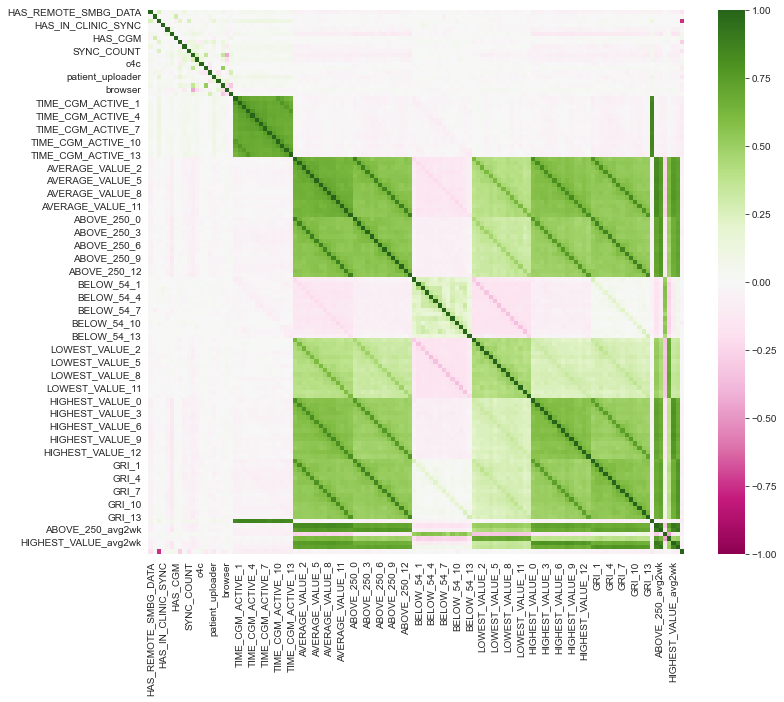

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
cor = X_train.corr()
sns.heatmap(cor, vmin=-1, vmax=1, cmap="PiYG");

In [72]:
import numpy as np
keep_columns = np.full(cor.shape[0], True)
for i in range(cor.shape[0] - 1):
    for j in range(i + 1, cor.shape[0] - 1):
        if (np.abs(cor.iloc[i, j]) >= 0.8): # 0.8 is the correlation threshold
            keep_columns[j] = False
selected_columns = X_train.columns[keep_columns]
X_train_reduced = X_train[selected_columns]

In [73]:
X_train_reduced.shape

(3304, 79)

In [74]:
# We also want to keep the 2-week average GRI variable if it is dropped
ind = [i for i, x in enumerate(X_train.columns == 'GRI_avg2wk') if x] 
keep_columns[ind] = True
selected_columns = X_train.columns[keep_columns]
X_train_reduced = X_train[selected_columns]

In [75]:
X_test_reduced = X_test[selected_columns]

In [76]:
print("The feature set has been reduced to " + 
      f"{X_train_reduced.shape[1]} features " +
      f"from {X.shape[1]} features.")

The feature set has been reduced to 80 features from 126 features.


In [77]:
X_train_reduced.columns

Index(['HAS_REMOTE_SMBG_DATA', 'HAS_REMOTE_CGM_DATA',
       'HAS_REMOTE_INSULIN_DATA', 'HAS_IN_CLINIC_SYNC', 'GENDER',
       'CURRENT_AGE', 'HAS_CGM', 'HAS_PUMP', 'HAS_METER', 'SYNC_COUNT',
       'APP_LENGTH', 'HAS_OTHER_COUNT', 'c4c', 'kiosk', 'logbook',
       'patient_uploader', 'server', 'android', 'browser', 'ios',
       'TIME_CGM_ACTIVE_0', 'TIME_CGM_ACTIVE_1', 'TIME_CGM_ACTIVE_2',
       'TIME_CGM_ACTIVE_3', 'TIME_CGM_ACTIVE_4', 'TIME_CGM_ACTIVE_5',
       'TIME_CGM_ACTIVE_6', 'TIME_CGM_ACTIVE_7', 'TIME_CGM_ACTIVE_8',
       'TIME_CGM_ACTIVE_9', 'TIME_CGM_ACTIVE_10', 'TIME_CGM_ACTIVE_11',
       'TIME_CGM_ACTIVE_12', 'TIME_CGM_ACTIVE_13', 'AVERAGE_VALUE_0',
       'AVERAGE_VALUE_1', 'AVERAGE_VALUE_2', 'AVERAGE_VALUE_3',
       'AVERAGE_VALUE_4', 'AVERAGE_VALUE_5', 'AVERAGE_VALUE_6',
       'AVERAGE_VALUE_7', 'AVERAGE_VALUE_8', 'AVERAGE_VALUE_9',
       'AVERAGE_VALUE_10', 'AVERAGE_VALUE_11', 'AVERAGE_VALUE_12',
       'AVERAGE_VALUE_13', 'BELOW_54_0', 'BELOW_54_1', 'BELOW_54

In [78]:
X_train.columns[:70]

Index(['HAS_REMOTE_SMBG_DATA', 'HAS_REMOTE_CGM_DATA',
       'HAS_REMOTE_INSULIN_DATA', 'HAS_IN_CLINIC_SYNC', 'GENDER',
       'CURRENT_AGE', 'HAS_CGM', 'HAS_PUMP', 'HAS_METER', 'SYNC_COUNT',
       'APP_LENGTH', 'HAS_OTHER_COUNT', 'c4c', 'kiosk', 'logbook',
       'patient_uploader', 'server', 'android', 'browser', 'ios',
       'TIME_CGM_ACTIVE_0', 'TIME_CGM_ACTIVE_1', 'TIME_CGM_ACTIVE_2',
       'TIME_CGM_ACTIVE_3', 'TIME_CGM_ACTIVE_4', 'TIME_CGM_ACTIVE_5',
       'TIME_CGM_ACTIVE_6', 'TIME_CGM_ACTIVE_7', 'TIME_CGM_ACTIVE_8',
       'TIME_CGM_ACTIVE_9', 'TIME_CGM_ACTIVE_10', 'TIME_CGM_ACTIVE_11',
       'TIME_CGM_ACTIVE_12', 'TIME_CGM_ACTIVE_13', 'AVERAGE_VALUE_0',
       'AVERAGE_VALUE_1', 'AVERAGE_VALUE_2', 'AVERAGE_VALUE_3',
       'AVERAGE_VALUE_4', 'AVERAGE_VALUE_5', 'AVERAGE_VALUE_6',
       'AVERAGE_VALUE_7', 'AVERAGE_VALUE_8', 'AVERAGE_VALUE_9',
       'AVERAGE_VALUE_10', 'AVERAGE_VALUE_11', 'AVERAGE_VALUE_12',
       'AVERAGE_VALUE_13', 'ABOVE_250_0', 'ABOVE_250_1', 'ABOVE_

In [79]:
X_train.columns[70:]

Index(['BELOW_54_8', 'BELOW_54_9', 'BELOW_54_10', 'BELOW_54_11', 'BELOW_54_12',
       'BELOW_54_13', 'LOWEST_VALUE_0', 'LOWEST_VALUE_1', 'LOWEST_VALUE_2',
       'LOWEST_VALUE_3', 'LOWEST_VALUE_4', 'LOWEST_VALUE_5', 'LOWEST_VALUE_6',
       'LOWEST_VALUE_7', 'LOWEST_VALUE_8', 'LOWEST_VALUE_9', 'LOWEST_VALUE_10',
       'LOWEST_VALUE_11', 'LOWEST_VALUE_12', 'LOWEST_VALUE_13',
       'HIGHEST_VALUE_0', 'HIGHEST_VALUE_1', 'HIGHEST_VALUE_2',
       'HIGHEST_VALUE_3', 'HIGHEST_VALUE_4', 'HIGHEST_VALUE_5',
       'HIGHEST_VALUE_6', 'HIGHEST_VALUE_7', 'HIGHEST_VALUE_8',
       'HIGHEST_VALUE_9', 'HIGHEST_VALUE_10', 'HIGHEST_VALUE_11',
       'HIGHEST_VALUE_12', 'HIGHEST_VALUE_13', 'GRI_0', 'GRI_1', 'GRI_2',
       'GRI_3', 'GRI_4', 'GRI_5', 'GRI_6', 'GRI_7', 'GRI_8', 'GRI_9', 'GRI_10',
       'GRI_11', 'GRI_12', 'GRI_13', 'TIME_CGM_ACTIVE_avg2wk',
       'AVERAGE_VALUE_avg2wk', 'ABOVE_250_avg2wk', 'BELOW_54_avg2wk',
       'LOWEST_VALUE_avg2wk', 'HIGHEST_VALUE_avg2wk', 'GRI_avg2wk',
       '

### Create a couple functions for visualizing results

In [80]:
# Load the tools needed for model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [81]:
# Function to print the accuracy and classification report
def print_acc_and_CR(y_test, model_predictions):
    # Calculate and display the model accuracy
    print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, model_predictions) * 100))
    # Calculate and display the classification report for the model
    print('Classification report: \n', classification_report(y_test, model_predictions))

In [82]:
# Function to display the confusion matrix
def display_confusion_matrix(y_test, model_predictions):
    # Calculate and display the confusion matrix
    model_confusionMatrix = confusion_matrix(y_test, model_predictions)
    # Create variables that will be displayed as text on the plot
    strings2 = np.asarray([['True Negatives \n', 'False Positives \n'], ['False Negatives \n', 'True Positives \n']])
    labels2 = (np.asarray(["{0} {1:g}".format(string, value)
                          for string, value in zip(strings2.flatten(),model_confusionMatrix.flatten())])
             ).reshape(2, 2)
    # Use a heat map plot to display the results
    sns.heatmap(model_confusionMatrix, annot=labels2, fmt='', vmin=0, annot_kws={"fontsize":17})
    plt.xlabel('Predicted value');
    plt.ylabel('Actual value');

### Check the performance of a super basic model
Where we assume users with GRI below 40 will stay below 40 and users with GRI above 40 will stay above 40 (i.e., no change in GRI in the future).

In [83]:
basic_predictions = X_test_reduced['GRI_avg2wk'] > 40

In [84]:
print_acc_and_CR(y_test, basic_predictions)

Accuracy: 86.32%
Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.89      0.88       461
           1       0.85      0.84      0.84       365

    accuracy                           0.86       826
   macro avg       0.86      0.86      0.86       826
weighted avg       0.86      0.86      0.86       826



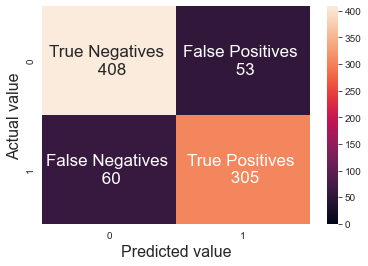

In [85]:
display_confusion_matrix(y_test, basic_predictions)

In [86]:
fraction_users_crossing_GRI_40 = (53 + 60) / len(y_test)

Only about 14% of users cross the GRI = 40 threshold from the average for the past to the future 2 week time periods. This is a small amount of the total numbe rof users, indicating that most users stay in a similar GRI range. It also indicates that we should expect to get most of our ML models predictive power out of this single variable (`GRI_avg2wk`).

###  Fit a Random Forest Classifier

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model

# Instantiate and fit the model
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train_reduced, y_train)

# Use the model to predict diabetes type
rfc_predictions = rfc.predict(X_test_reduced)

In [88]:
print_acc_and_CR(y_test, rfc_predictions)

Accuracy: 86.92%
Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       461
           1       0.85      0.85      0.85       365

    accuracy                           0.87       826
   macro avg       0.87      0.87      0.87       826
weighted avg       0.87      0.87      0.87       826



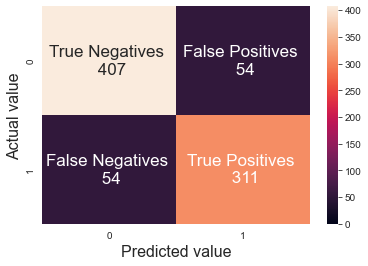

In [89]:
display_confusion_matrix(y_test, rfc_predictions)

Feature ranking:
1. GRI_avg2wk (feature 78) (0.209625)
2. AVERAGE_VALUE_0 (feature 34) (0.070902)
3. AVERAGE_VALUE_1 (feature 35) (0.044240)
4. AVERAGE_VALUE_2 (feature 36) (0.041567)
5. AVERAGE_VALUE_12 (feature 46) (0.037425)
6. AVERAGE_VALUE_5 (feature 39) (0.037363)
7. AVERAGE_VALUE_3 (feature 37) (0.036208)
8. AVERAGE_VALUE_8 (feature 42) (0.035234)
9. AVERAGE_VALUE_9 (feature 43) (0.034251)
10. AVERAGE_VALUE_13 (feature 47) (0.030140)
11. AVERAGE_VALUE_6 (feature 40) (0.029346)
12. AVERAGE_VALUE_10 (feature 44) (0.025226)
13. AVERAGE_VALUE_4 (feature 38) (0.024881)
14. AVERAGE_VALUE_11 (feature 45) (0.024741)
15. AVERAGE_VALUE_7 (feature 41) (0.022315)
16. BELOW_54_avg2wk (feature 76) (0.015694)
17. LOWEST_VALUE_avg2wk (feature 77) (0.013761)
18. LOWEST_VALUE_8 (feature 70) (0.011641)
19. LOWEST_VALUE_6 (feature 68) (0.010170)
20. LOWEST_VALUE_0 (feature 62) (0.009773)


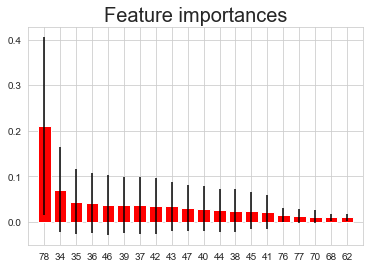

In [90]:
# Set a number of features to consider when looking at rank/importance
n_features = 20

# Use Random Forest to get feature ranks/importances for each feature
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# Look at importance for first 20 features
for f in range(n_features):#range(X_train_reduced.shape[1]):
    print("%d. %s (feature %d) (%f)" %
          (f + 1, X_train_reduced.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(n_features), importances[indices[:n_features]],
        color="r", yerr=std[indices[:n_features]], align="center")
plt.xticks(range(n_features), indices[:n_features])
plt.xlim([-1, n_features]);

###  Fit a Logistic Regression Model

In [91]:
# Import the tool needed
from sklearn.linear_model import LogisticRegression

# Instantiate and train the model
logregmodel = LogisticRegression(max_iter=100000, class_weight="balanced")
logregmodel.fit(X_train_reduced,y_train)

# Make predictions
logregmodel_predictions = logregmodel.predict(X_test_reduced)

In [92]:
print_acc_and_CR(y_test, logregmodel_predictions)

Accuracy: 86.68%
Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.87      0.88       461
           1       0.84      0.86      0.85       365

    accuracy                           0.87       826
   macro avg       0.86      0.87      0.87       826
weighted avg       0.87      0.87      0.87       826



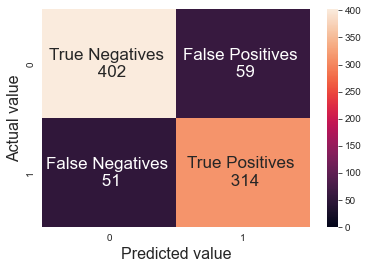

In [93]:
display_confusion_matrix(y_test, logregmodel_predictions)

The default parameters for the random forest classifier and the logistic regression model give similar performance.

### K-Fold validation and recursive feature elimination

In [94]:
# We import the modules we need from sci-kit learn
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
import operator

In [95]:
# We will normalize our data first, so that our coefficients will conceptually relate to each variable's importance
X_train_std = StandardScaler().fit_transform(X_train_reduced)

# Stratified K-Fold is a version of K-Fold that keeps class ratios, we will separate the training data into 8 sets
K = 8
k_fold = StratifiedKFold(n_splits=K)

# Instatiate the logistic regression model
# Note that we need to increase the maximum number of iterations from the default to get the analysis to run
lr_model = LogisticRegression(max_iter=600)

# Run the recursive feature elimination with cross validation analysis and fit the model
rfecv = RFECV(estimator=lr_model, step=1, cv=k_fold, scoring='accuracy')
rfecv.fit(X_train_std, y_train)

RFECV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
      estimator=LogisticRegression(max_iter=600), scoring='accuracy')

/Users/jasonphiltron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


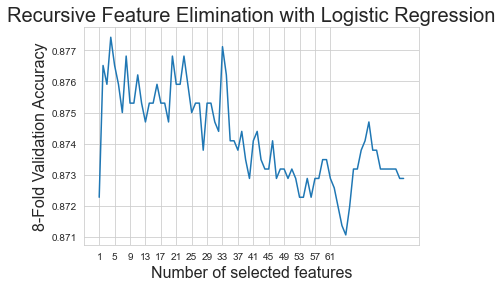

In [96]:
# Create a plot to show the model accuracy as features are added one at a time
plt.figure()
plt.title('Recursive Feature Elimination with Logistic Regression')
plt.xlabel('Number of selected features')
plt.ylabel('{}-Fold Validation Accuracy'.format(K))

# The variable grid_scores_ is the list of accuracy scores for the different number of features
plt.plot(range(1, len(rfecv.grid_scores_) + 1), 
         [np.array(x).mean() for x in rfecv.grid_scores_]);
#plt.grid(True)
plt.xticks(np.arange(1, 65, step=4));

As expected, most of the predictive power is derived from the first feature -- the average GRI over the past 2 weeks. This isn't surprising, since very few users cross the GRI = 40 threshold in the test dataset, as mentioned above. Although we have many features that correspond to previous days' data, none of these features appear to given a significant amount of predictive power on their own. However, if a small amount of predictive power could be gained from multiple features in series, we might expect a gradient boosted algorithm to perform a little better. If there is not significant predictive power in these other features, then a gradient boosted classifier may not provide a better prediction.

### Gradient Boosted Classifier

In [97]:
from xgboost import XGBClassifier

# Instantiate and fit the model
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_reduced, y_train)

# Make predictions
xgb_predictions = xgb.predict(X_test_reduced)

In [98]:
print_acc_and_CR(y_test, xgb_predictions)

Accuracy: 85.71%
Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.89      0.87       461
           1       0.86      0.81      0.83       365

    accuracy                           0.86       826
   macro avg       0.86      0.85      0.85       826
weighted avg       0.86      0.86      0.86       826



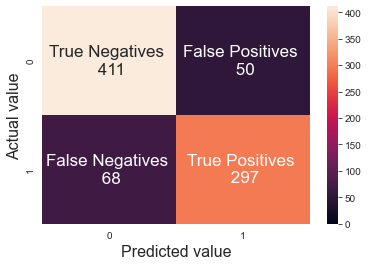

In [99]:
display_confusion_matrix(y_test, xgb_predictions)

The gradient boosted classifier does not provide any gain over use of logistic regression or random forest classifier ML models. This suggests that the ability to predict future GRI above 40 may be a trivial problem, largely solved by looking at past GRI, or that we have not found features which contain the information needed to create such a prediction.

### A quick look at how much GRI changes
We'll look at the users than crossed the threshold of GRI = 40, and users overall

In [100]:
crossing_users_indices = [i for i, x in enumerate(y) if x == 1]

In [101]:
GRI_changes_crossing_users = future_data[crossing_users_indices] - \
    X['GRI_avg2wk'][crossing_users_indices]

In [102]:
GRI_changes_crossing_users.describe()

count    1726.000000
mean        1.380259
std        12.091505
min       -59.122286
25%        -5.601107
50%         1.709714
75%         8.880214
max        44.537571
dtype: float64

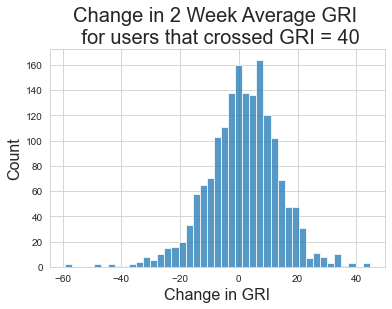

In [103]:
sns.histplot(x=GRI_changes_crossing_users)
plt.xlabel('Change in GRI')
plt.title('Change in 2 Week Average GRI \n for users that crossed GRI = 40');

As shown above, for the 1726 users (out of 4130) that cross the GRI = 40 threshold, the average change is small (1.4). However, some users do have large changes in GRI! It will be interesting to try to capture something about those users. Below, we plot a similar histogram of the change in GRI but for all users.

In [104]:
GRI_changes_all_users = future_data - X['GRI_avg2wk']

In [105]:
GRI_changes_all_users.describe()

count    4130.000000
mean       -0.111433
std         9.864801
min       -69.073714
25%        -5.417964
50%         0.051143
75%         5.547179
max        44.537571
dtype: float64

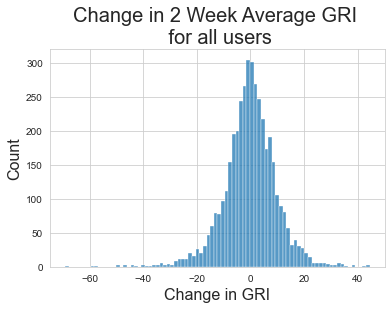

In [106]:
sns.histplot(x=GRI_changes_all_users)
plt.xlabel('Change in GRI')
plt.title('Change in 2 Week Average GRI \n for all users');

In [107]:
# Let's calculate the fraction of users that have a GRI that increases by at least 10
# this may be something that is more interesting and clinically useful to predict
((future_data - X['GRI_avg2wk']) > 10).astype(int).sum() / len(X)

0.12033898305084746

### Using autoML to find an optimized model

In [ ]:
from supervised.automl import AutoML
automl = AutoML(algorithms=["Extra Trees","Xgboost",'Random Forest'], 
                train_ensemble=False, explain_level=2)
automl.fit(X_train_reduced, y_train)

In [ ]:
auto_pred = automl.predict(X_test)
print("accuracy:", accuracy(y_test_new, auto_pred))
print("precision:", precision(y_test_new, auto_pred,average = 'macro'))
print("recall:", recall(y_test_new, auto_pred,average = 'macro'))
print("f1 score:", f1_score(y_test_new, auto_pred,average = 'macro'))
print("confusion matrix:")
print(confusion_matrix(y_test, auto_pred))

In [ ]:
automl.get_leaderboard()

### Using TPOT to find an optimized model

In [75]:
%%time
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=4, # set to 4 to run faster for testing
                     population_size=40,
                     scoring='neg_log_loss',
                     verbosity=2,
                     random_state=42)
tpot.fit(X_train_reduced, y_train)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.3240182649839661

Generation 2 - Current best internal CV score: nan

Generation 3 - Current best internal CV score: nan

Generation 4 - Current best internal CV score: nan

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=2, max_features=1.0, min_samples_leaf=8, min_samples_split=5, n_estimators=100, subsample=0.6500000000000001)
CPU times: user 17min 42s, sys: 5min 28s, total: 23min 11s
Wall time: 14min 23s


TPOTClassifier(generations=4, population_size=40, random_state=42,
               scoring='neg_log_loss', verbosity=2)

In [76]:
print(f"TPOT score on test data: {tpot.score(X_test_reduced, y_test):.2f}")
tpot.export('tpot_GRI_pipeline.py')

TPOT score on test data: -0.35


### Concluding remarks

1. Glycemic risk depends on many factors and can undergo large variations in short time periods because the underlying glucose measurements that the calculation for GRI is based on are highly variable.
2. Several base ML models were created to predict whether an average Glycemic Risk Indicator (GRI) score for a future 2-week period would be above 40, based on the prior 2 weeks of CGM data. These models all gave an accuracy in the low to mid-80% range.
3. TPOT was also used to find an optimal model (runtime ~1 hour) via autoML algorithms.

### Future work

- Revise this draft notebook (including by converting DATE to datetime format and training/testing with the full range of data available (data is available over a 3 month period, and only 1 month (4 weeks) of data was used here).
- Refine models (hyperparameter tuning, etc.)
- Use or make additional features
- Try different feature reduction techniques (e.g., PCA)
- Try classifying for a different outcome (e.g., increase in GRI by X amount in future, or predict TIR)
- Try polynomial regression to predict future GRI and measure the MSE
- Also: look deeper in literature review